In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim_models

from pymystem3 import Mystem
from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from langdetect import detect as detect_lang
from datasets import Dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tylerdurden/opt/miniconda3/envs/tf/lib/python3.9/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if

In [2]:
tqdm.pandas()

# Agenda

1. [Load and Preprocess Data](#Load_and_Preprocess_Data)
2. [Clustering Algorithms](#Clustering_Algorithms)
3. [Dimensionality Reduction](#Dimensionality_Reduction) 
3. [Text Embeddings clustering](#Text_Embeddings_clustering)
4. [Topic Modelling](#Topic_Modelling)
4. [Homework](#Homework)

# Resources
- https://www.kaggle.com/datasets/vladimirsydor/ru-propaganda-2022-year
- https://scikit-learn.org/stable/modules/clustering.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://en.wikipedia.org/wiki/Convex_set
- https://en.wikipedia.org/wiki/Isotropy
- https://en.wikipedia.org/wiki/Principal_component_analysis
- https://scikit-learn.org/stable/modules/decomposition.html#pca
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
- https://radimrehurek.com/gensim/models/ldamodel.html
- https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
- https://github.com/MaartenGr/BERTopic
- https://maartengr.github.io/BERTopic/index.html

<a id='Load_and_Preprocess_Data'></a>
# Load and Preprocess Data

In [3]:
os.listdir("../data/ru_propaganda_2022_year/")

['news_embeddings.npy', 'text_table.csv', 'text_table_processed.csv']

In [12]:
df = pd.read_csv("../data/ru_propaganda_2022_year/text_table.csv")

In [13]:
df.shape

(1572731, 5)

In [14]:
df.head()

Title  \
0                                                NaN   
1  Опять оккупанты что-то попутали. Рассказывать ...   
2                                                NaN   
3  Опять оккупанты что-то попутали. Рассказывать ...   
4  Опять оккупанты что-то попутали. Рассказывать ...   

                                                Text  \
0  [18/20] 📚@Geo_Hub93 📚\n\n📚In which of the foll...   
1  Вот, россияне, посмотрите на действительно сво...   
2  Русский солдат – фашистский оккупант!\n\nВот к...   
3                                                NaN   
4                                                NaN   

                              Saved at        Date      Time  
0  2022-03-13 12:21:06.349070200+00:00  2022-03-13  12:12:28  
1  2022-03-13 12:21:10.126565500+00:00  2022-03-13  09:38:01  
2  2022-03-13 12:21:10.529583400+00:00  2022-03-13  12:20:08  
3  2022-03-13 12:21:11.009456500+00:00  2022-03-13  09:38:01  
4  2022-03-13 12:21:11.569105200+00:00  2022-03-13  09:38:01

In [15]:
df.isna().sum()

Title       1115595
Text           9185
Saved at       5606
Date           5606
Time           5607
dtype: int64

In [16]:
df.isna().sum() / df.shape[0]

Title       0.709336
Text        0.005840
Saved at    0.003565
Date        0.003565
Time        0.003565
dtype: float64

In [17]:
df = df[~df[["Text", "Saved at", "Date", "Time"]].isna().any(axis=1)].reset_index(drop=True)

In [18]:
df.shape

(1557939, 5)

In [19]:
df = df.sample(1000)

In [21]:
def detect_lang_with_excep(input):
    try:
        return detect_lang(input)
    except:
        return "none"

df["lang"] = df["Text"].progress_apply(detect_lang_with_excep)
df["lang"].value_counts()

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 316.20it/s]


ru      648
en      240
uk       49
fr       15
de       11
es        9
bg        7
it        2
none      2
lt        2
af        2
ro        2
no        2
et        1
da        1
sv        1
mk        1
pl        1
bn        1
ml        1
hi        1
sl        1
Name: lang, dtype: int64

## Date dependency 

In [22]:
df["Date"] = pd.to_datetime(df["Date"])

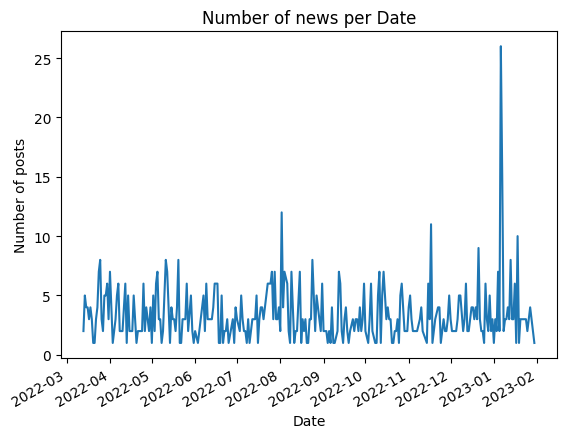

In [23]:
plt.title("Number of news per Date")
df.groupby("Date")["Text"].count().plot()
plt.xlabel("Date")
plt.ylabel("Number of posts")
plt.show()

## Text Visualisation

In [24]:
from string import punctuation

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
en_stopwords = stopwords.words("english")


ru_stopwords.extend(en_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerdurden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
mystem = Mystem()
def preprocess(text, lemmatize=True):
    if lemmatize:
        text = re.sub(r"http\S+", "", text)
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in ru_stopwords\
                  and token != " "\
                  and token.strip() not in punctuation]
        
        
    else:
        tokens = gensim.utils.simple_preprocess(text)
        tokens = [token for token in tokens if (token not in\
                    gensim.parsing.preprocessing.STOPWORDS and 
                    token not in ru_stopwords)]
        
    text = " ".join(tokens)
    return text

In [45]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

df["Text_processed"] = df["Text"].apply(preprocess)

<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
/var/folders/8r/80qp0xcx3p986rp4th0s50140000gn/T/ipykernel_11719/4199793903.py:5: DeprecationWarning: invalid escape sequence \.
  input = re.sub("\.+", ".", input)
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tylerdurden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# df.to_csv("../data/ru_propaganda_2022_year/text_table_processed.csv", index=False)

In [16]:
df = pd.read_csv("../data/ru_propaganda_2022_year/text_table_processed.csv", converters={"Date": pd.to_datetime})
df["lang"].value_counts()

KeyboardInterrupt: 

In [27]:
df = df[df["lang"] == "ru"].reset_index(drop=True)

In [28]:
df.shape

(648, 7)

## Extract News embeddings

In [31]:
sent_emb_model = SentenceTransformer("DeepPavlov/rubert-base-cased", device="mps")

No sentence-transformers model found with name /Users/tylerdurden/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/tylerdurden/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exac

In [46]:
news_embeddings = sent_emb_model.encode(df["Text_processed"].to_list(), show_progress_bar=True, batch_size=100)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# np.save(
#     "../data/ru_propaganda_2022_year/news_embeddings.npy",
#     news_embeddings
# )

In [16]:
news_embeddings = np.load("../data/ru_propaganda_2022_year/news_embeddings.npy")
assert news_embeddings.shape[0] == df.shape[0]

In [17]:
# Drop NaN rows, in order to keep df and news_embeddings alligned

df = df[~df["Text_processed"].isna()]
news_embeddings = news_embeddings[df.index.values]
df = df.reset_index(drop=True)

<a id='Clustering_Algorithms'></a>
# [Clustering Algorithms](https://scikit-learn.org/stable/modules/clustering.html)

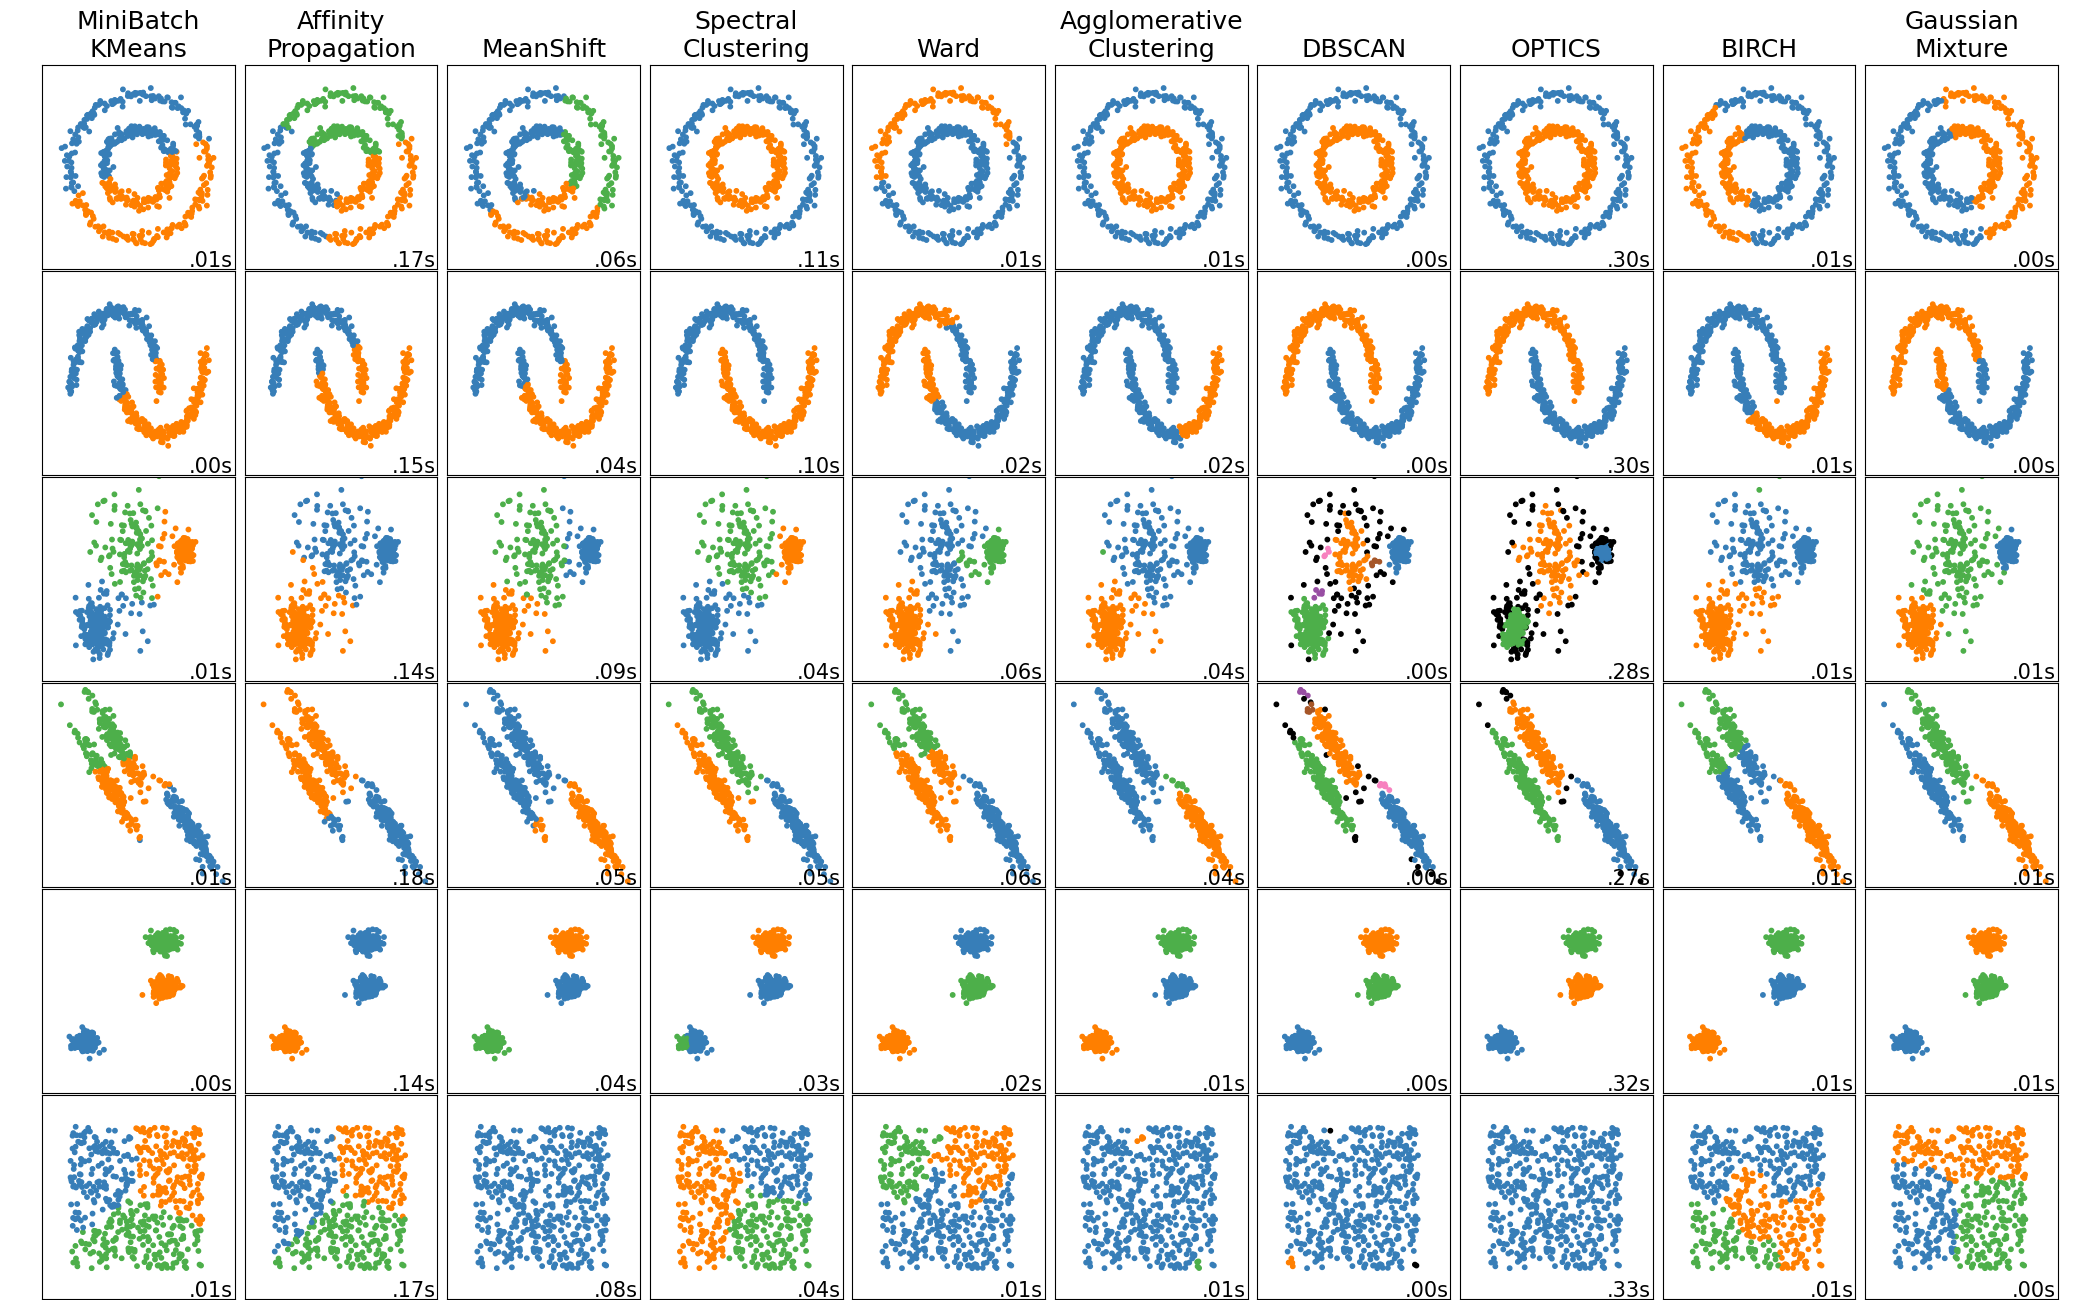

## [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

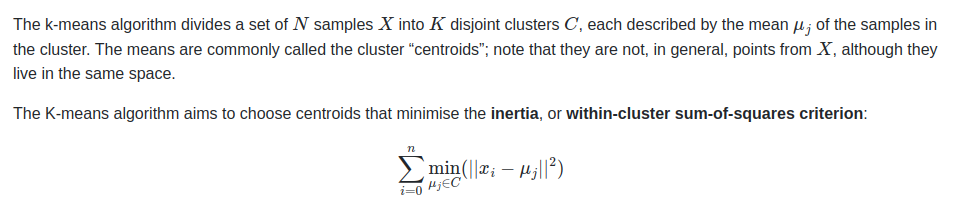

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:
- Inertia makes the assumption that clusters are [convex](https://en.wikipedia.org/wiki/Convex_set) and [isotropic](https://en.wikipedia.org/wiki/Isotropy), which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as [Principal component analysis (PCA)](https://scikit-learn.org/stable/modules/decomposition.html#pca) prior to k-means clustering can alleviate this problem and speed up the computations.

**Left - CONVEX** || **Right - NOT CONVEX**

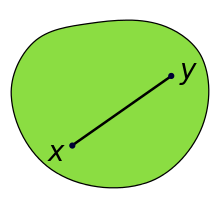
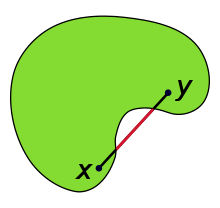

## [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher `min_samples` or lower`eps` indicate higher density necessary to form a cluster.

More formally, we define a core sample as being a sample in the dataset such that there exist `min_samples` other samples within a distance of `eps`, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples. Intuitively, these samples are on the fringes of a cluster.

Any core sample is part of a cluster, by definition. Any sample that is not a core sample, and is at least `eps` in distance from any core sample, is considered an outlier by the algorithm.

<a id='Dimensionality_Reduction'></a>
# Dimensionality Reduction

## [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

[Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. Formally, PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by linearly transforming the data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data. Many studies use the first two principal components in order to plot the data in two dimensions and to visually identify clusters of closely related data points

**PCA of a multivariate Gaussian distribution centered at (1,3) with a standard deviation of 3 in roughly the (0.866, 0.5) direction and of 1 in the orthogonal direction. The vectors shown are the eigenvectors of the covariance matrix scaled by the square root of the corresponding eigenvalue, and shifted so their tails are at the mean.**

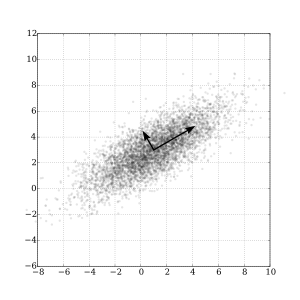

## [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is based on Stochastic Neighbor Embedding. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. 

**T-SNE embeddings of MNIST dataset**

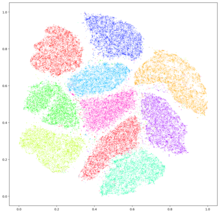

<a id='Text_Embeddings_clustering'></a>
# Text Embeddings clustering

## Pipeline 

1. Take some Texts subset (just as an example)
2. Aplly TSNE and visualise 
3. According to visualisation - pick number of Clusters for KMeans. TODO: Try to pick n_clusters using [clustering metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
4. Examine KMeans clusters 
5. Try to estimate optimal distance treshold for DBSCAN from KMeans clustres 
6. Examine DBSCAN clusters 

TODO: Try to repeat this Pipeline, inplacing TSNE with PCA on the first step 

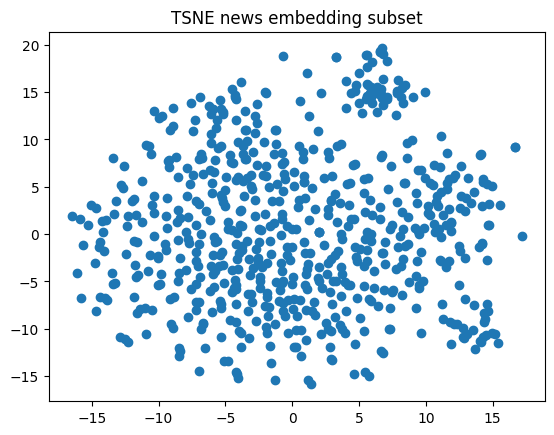

In [47]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(news_embeddings[:1000])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

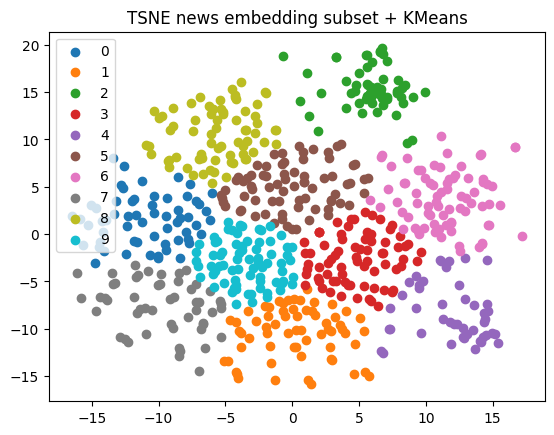

In [48]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=10, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [50]:
df.iloc[:1000][kmeans_clusts_news_embeddings_subset == 2].Text_processed.to_list()

['украина уруш ичидага жосуслик уруш россия ва ғарб қарама қаршилиги нима билан тугайди россия ва ғарб ўртасидаги узоқ йиллик жосуслик можарось украинадаг уруш туфайль авж олмоқда аммо россия махфий хизматлари нимад гумон қилинмоқда ва уларнинг ғарб пойтахтларидан ҳайдаб чиқарилиши путиннинг хориждаг махфий операцияларига қандай таъсир қилади украина уруш ичидага жосуслик уруш россия ва ғарб қарама қаршилиги нима билан тугайди bbc news zbek россия ва ғарб ўртасидаги узоқ йиллик жосуслик можарось украинадаг уруш туфайль авж олмоқда аммо россия махфий хизматлари нимад гумон ...',
 'украинский беженка показывать свой золотой хоромы свой жилье ирландия приютить местный туалет душа  —  улица кухня  —  конец участок хлам весь территория сон  —  трейлер просто сказка ... подписываться 360',
 'напоминать весь комментарий нарушать правило удалять',
 'сегодня село яковлевка 11.00 час состояться митинг концерт  « крымский весна »,  посвящать день присоединение крым рф митинг концерт завершаться а

In [21]:
# TODO: drop duplicates by `substrings` 
df_no_dupl = df.drop_duplicates("Text_processed")
news_embeddings_no_dupl = news_embeddings[df_no_dupl.index.values]
df_no_dupl = df_no_dupl.reset_index(drop=True)

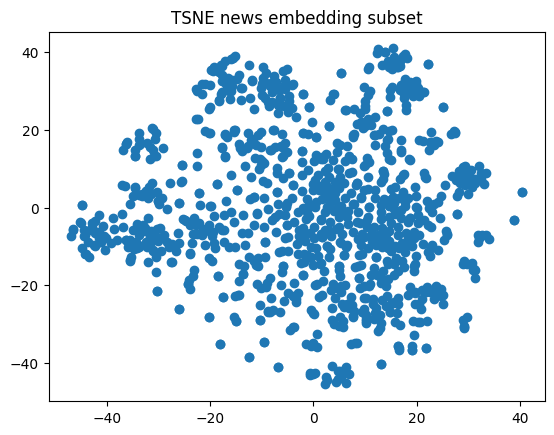

In [22]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(news_embeddings_no_dupl[:1000])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

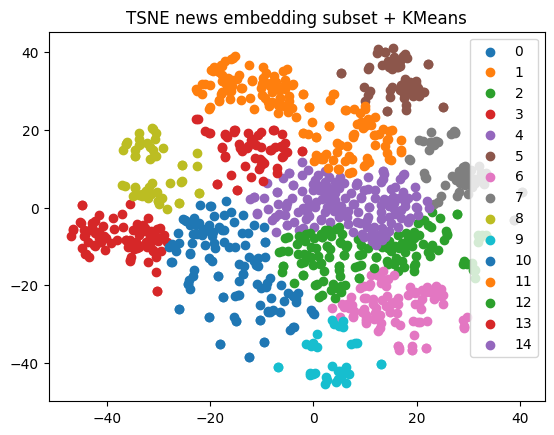

In [23]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=15, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [24]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset == 5].Text.to_list()[:10]

['Киев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий. https://kaktus.media/456168\r\nСоветник президента Украины: Россия уже адекватнее смотрит на ситуацию\r\nКиев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий.\r\nhttps://kaktus.media/456168',
 'Четвертый очный раунд переговоров между Россией и Украиной может пройти в начале следующей недели\nПодробнее здесь:\xa0https://bit.ly/37ewjHJ',
 '❗️ Михаил Подоляк выпустил видеообращение, в котором рассказал о переговорном процессе.\n\n"Для понимания. Представители РФ на переговорах уже не ультимативно что-либо говорят, а внимательно слушают наши предложения. Украина не уступит свои позиции. Наши требования – окончание войны и вывод русских войск. Вижу, что понимание этого процесса и диалог", – также заявил Михаил Подоляк в своем Twitter.\n\nVESTI https://t.me/vestiukr ',
 'Требования, которые предъявляет Россия к Украине – простые и понятные. При их выполнении спецоперация заве

In [25]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset == 7].Text.to_list()[:10]

['Министр финансов РФ заявил, что около $300 млрд золотовалютных резервов Центробанка заморожены из-за санкций.',
 'Лидер Чеченской республики заслушал доклад силовиков об эвакуации детей из детского дома.\nЧеченские СМИ утверждают, что Кадыров прибыл на Украину\nЛидер Чеченской республики заслушал доклад силовиков об эвакуации детей из детского дома\nhttps://anews.com/136525555-chechenskie-smi-utverzhdajut-chto-kadyrov-pribyl-na-ukrainu.html',
 'Всплеск спроса на драгметалл произошёл после начала спецоперации на Украине\nhttps://secretmag.ru/investment/lyudi-po-vsemu-miru-brosilis-skupat-zoloto-13-03-2022.htm?utm_source..\nhttps://secretmag.ru/investment/lyudi-po-vsemu-miru-brosilis-skupat-zoloto-13-03-2022.htm?utm_source=sfvk&amp;utm_medium=social',
 '▪ Рамзан Кадыров приехал на Украину, пишут СМИ.\n▪ На видео глава Чечни общается с военнослужащими и заслушивает их доклады.\nКадыров приехал на Украину и выслушал доклады военнослужащих\n▪ Рамзан Кадыров приехал на Украину, пишут СМИ.\

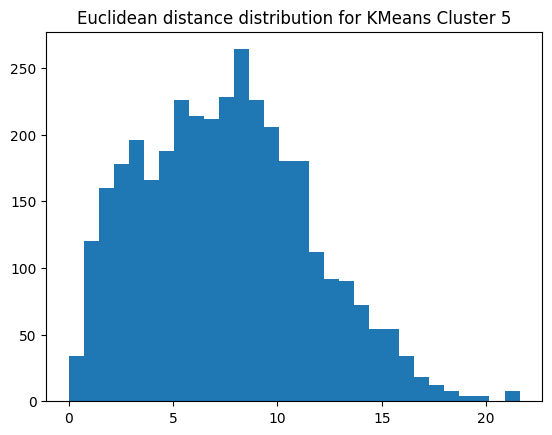

In [26]:
estimated_dists = pairwise_distances(
    tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == 5]
).flatten()

plt.title("Euclidean distance distribution for KMeans Cluster 5")
plt.hist(estimated_dists[estimated_dists != 0], bins=30)
plt.show()

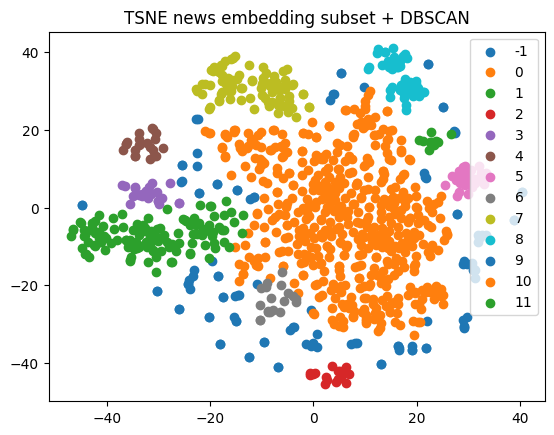

In [27]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=4,
    min_samples=10
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [28]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 4].Text.to_list()[:10]

['СМИ пишут, что в Украину приехал Кадыров. Также появилось вот такое видео в районе ДНР.\nОфициальных подтверждений пока что нет\nКадыровцы',
 '🔺 Рамзан Кадыров приехал на Украину, сообщает ЧГТРК «Грозный». Канал опубликовал ролик, на котором глава Чечни слушает доклады командиров о ходе спецоперации\n\n@lentadnya',
 '"Чеченский СОБР едет в зону специальной военной операции".\n\nМинистр Чеченской Республики по национальной политике, внешним связям, печати и информации Ахмед Дудаев опубликовал это видео в своем Telegram-канале\n\n https://t.me/akhmeddudaev/125 Ранее СМИ сообщали, что Рамзан Кадыров прибыл на Украину и находится под Киевом. Официального подтверждения этой информации нет.\n\n@infomoscow24',
 'Глава Чечни Рамзан Кадыров, приехал в зону проведения операции на Украине\nРанее Russia Today сообщил, что Рамзан Кадыров, возможно, приехал в зону проведения операции на Украине.\nСейчас ЧГТРК "Грозный" подтвердил, что чеченский лидер Рамзан Кадыров находится в зоне специальной опе

In [29]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 2].Text.to_list()[:10]

['На антивоенную акцию у Гостиного двора в этот раз пришло не так много людей, но это не помешало силовикам задержать не менее 53 человек. В автозаки увели более десятка журналистов, есть сообщения о задержании случайных прохожих.\nЧитайте на зеркале «Бумаги»: https://ppr.today/hGS4YvW\nРоскомнадзор заблокировал сайт «Бумаги» из-за освещения ситуации в Украине, но мы продолжаем работу. Установите VPN: https://ppr.today/65Q689i',
 '«Будете мешать — будем бить сильнее». Люди в России выходят на улицы против войны с Украиной.\n(зеркало: https://whatisyournameinsider.com/news/249251)\nНа видео — силовики вшестером задерживают прохожего в Петербурге, который снимал протесты на телефон. Запись «Новой газеты».\nвшестером',
 'В Москве на Манежной площади проходит акция против боевых действий на Украине. Митингующих задерживают',
 '«Ковчег» — проект для людей, которые уехали из России по политическим причинам. Чем он может помочь?\nhttps://ppr.today/9OeiIsh\nРоскомнадзор заблокировал сайт «Бума

In [30]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 8].Text.to_list()[:10]

['Киев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий. https://kaktus.media/456168\r\nСоветник президента Украины: Россия уже адекватнее смотрит на ситуацию\r\nКиев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий.\r\nhttps://kaktus.media/456168',
 'Четвертый очный раунд переговоров между Россией и Украиной может пройти в начале следующей недели\nПодробнее здесь:\xa0https://bit.ly/37ewjHJ',
 'Член российской делегации на переговорах с Украиной Леонид Слуцкий — о прогрессе в диалоге с Киевом: Если сравнивать позиции обеих делегаций на переговорах в самом их начале и сегодня, то мы увидим существенный прогресс. \n\nПо словам депутата, этот прогресс может перерасти в самое ближайшее время в единую позицию обеих делегаций, в документы для подписания\n\n@truekpru',
 '⚡️Прогресс в переговорах между Россией и Украиной в ближайшее время может перерасти в единую позицию обеих делегаций, заявил Слуцкий.',
 '⚡️ Член российской делегаци

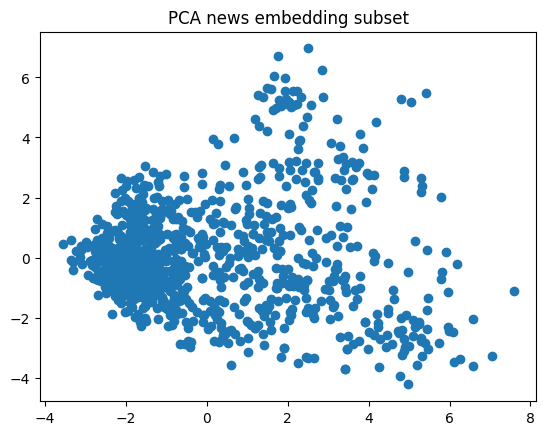

In [31]:
pca_news_embeddings_subset = PCA(random_state=42).fit_transform(news_embeddings_no_dupl[:1000])

plt.title("PCA news embedding subset")
plt.scatter(pca_news_embeddings_subset[:,0], pca_news_embeddings_subset[:,1])
plt.show()

# TODO: Try to twick `svd_solver` and apply different clustering approaches

## Example, where it does not work

In [32]:
dec_2022_mask = df_no_dupl["Date"].apply(lambda x: x.month).isin([12])
print(f"Number of unique News for December of 2022 = {dec_2022_mask.sum()}")

Number of unique News for December of 2022 = 70657


In [33]:
dec_2022_df = df_no_dupl[dec_2022_mask].reset_index(drop=True)
dec_2022_news_embeddings = news_embeddings_no_dupl[dec_2022_mask.values]

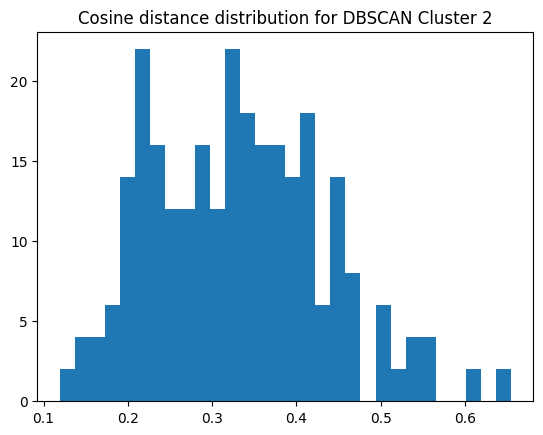

In [34]:
cosine_dists = pairwise_distances(
    news_embeddings_no_dupl[:1000][dbscan_clusts_news_embeddings_subset == 2],
    metric="cosine"
).flatten()

plt.title("Cosine distance distribution for DBSCAN Cluster 2")
plt.hist(cosine_dists[cosine_dists != 0], bins=30)
plt.show()

In [35]:
dbscan_clusts_dec_2022_news_embeddings = DBSCAN(
    eps=0.2,
    min_samples=10,
    metric="cosine",
).fit_predict(dec_2022_news_embeddings)

In [36]:
pd.Series(dbscan_clusts_dec_2022_news_embeddings).value_counts()

 0     57276
-1     13078
 2        52
 3        36
 6        30
 4        26
 1        21
 13       20
 14       17
 7        17
 15       14
 5        13
 10       11
 12       11
 17        9
 16        8
 9         6
 11        6
 8         6
dtype: int64

In [37]:
dec_2022_df[dbscan_clusts_dec_2022_news_embeddings==3].Text.to_list()[:10]

['Последние новости и сводки о ходе спецоперации на Украине от известного журналиста и блогера Юрия Подоляки: наступление на Донецком направлении, борьба за Марьинку, сражение за Артемовск, состояние украинской энергетической отрасли.\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022',
 'Последние новости и сводки о ходе спецоперации на Украине от известного журналиста и блогера Юрия Подоляки: наступление на Донецком направлении, борьба за Марьинку, сражение за Артемовск, состояние украинской энергетической отрасли.\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022\r\nРепортаж Юрия Подоляки. Большая игра. Фрагмент выпуска от 01.12.2022',
 'Последние новости и сводки о ходе спецоперации на Украине от известного журналиста и блогера Юрия Подоляки: продвижение на Сватовском и Артемовском направлении, передислокация ВСУ, атаки в районе Водяново, бои за Марьинку, судьба украинской п

In [38]:
dec_2022_df[dbscan_clusts_dec_2022_news_embeddings==15].Text.to_list()[:10]

['1 декабря. События дня.\n#смоленск #россия #украина #спецоперация #событиядня\r\n1 декабря. События дня\r\n«Единая Россия» приглашает смолян присоединиться к акции «Новогодняя почта» ...\r\nhttps://smolgazeta.ru/daylynews/106305-1-dekabrya-sobytiya-dnya.html',
 '2 декабря. События дня.\n#смоленск #россия #украина #событиядня #сво\r\n2 декабря. События дня\r\nДля погибших на Украине польских наёмников вынуждены открыть отдельное ...\r\nhttps://smolgazeta.ru/daylynews/106341-2-dekabrya-sobytiya-dnya.html',
 '8 декабря. События дня.\n#смоленск #россия #украина #спецоперация #сво #событиядня\r\n8 декабря. События дня\r\nАлексей Островский сделал контрольные звонки семьям мобилизованных ...\r\nhttps://smolgazeta.ru/daylynews/106497-8-dekabrya-sobytiya-dnya.html',
 '9 декабря. События дня.\n#смоленск #россия #украина #спецоперация #событиядня\r\n9 декабря. События дня\r\nСмоленские росгвардейцы провели урок мужества для кадетов. ...\r\nhttps://smolgazeta.ru/daylynews/106519-9-dekabrya-soby

## Conclusions 

**Use Cases**
- Contextual duplicates merging
- Text exploratary data analysis

**Main Problems**
- Requires hard hyper-parameter tunning  
- Optimal parameters for one subset may not be optimal for another one
- Lacks some good metrics 
- Hardly rely on the shape of dataspace

<a id='Topic_Modelling'></a>
# Topic Modelling

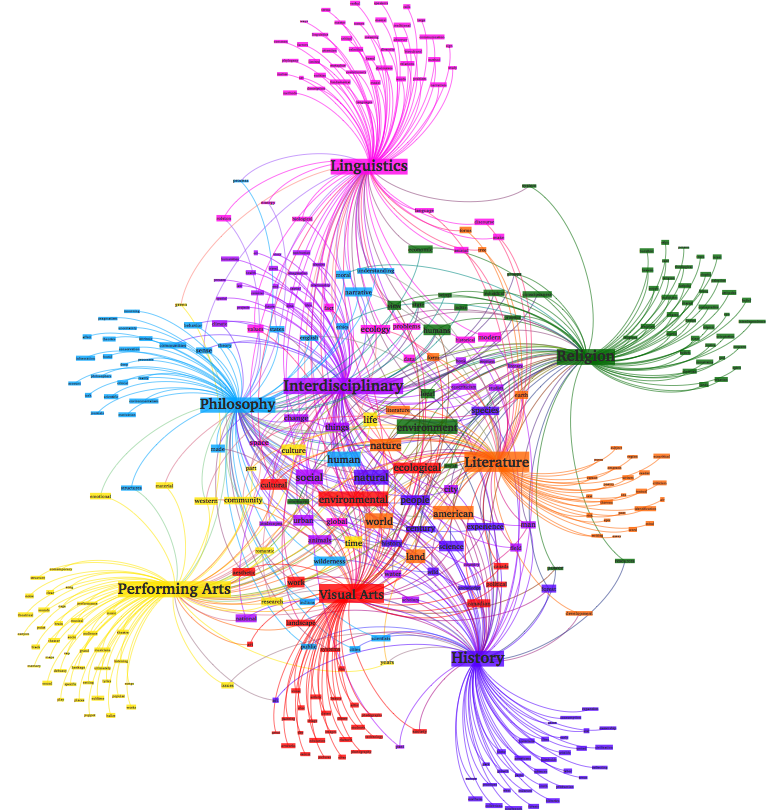

## [LDA Model](https://radimrehurek.com/gensim/models/ldamodel.html)

[Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

In natural language processing, Latent Dirichlet Allocation (LDA) is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. The LDA is an example of a topic model. In this, observations (e.g., words) are collected into documents, and each word's presence is attributable to one of the document's topics. Each document will contain a small number of topics. 

In [39]:
nltk.download("stopwords")
ru_stopwords = stopwords.words("russian")
ru_stopwords_puncts = set(ru_stopwords) | set(string.punctuation)

[nltk_data] Downloading package stopwords to /home/vova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
docs = []
for d in tqdm(df_no_dupl.iloc[:1000]['Text_processed'].to_list()):
    docs.append(
        [el.lower() for el in tokenize.word_tokenize(d) if el.lower() not in ru_stopwords_puncts]
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2448.40it/s]


In [41]:
# Create Dictionary
vocab = corpora.Dictionary(docs)
# doc2bow means Doc transformed to Bag of Words
corpus = [vocab.doc2bow(text) for text in docs]
# View
print(
    f"Text:\n{' '.join(docs[0])}\n\n"
    f"Text BOW:\n{corpus[0]}"
)

Text:
россияне посмотрите действительно свободных людей такое видели по-телевизору хотя пиздец это мелитополь которому оккупанты запретили протесты подбирая выражений скажу хуй клали запреты каких-то грязных захватчиков последняя прочитанная книга которых букварь смотрите видео чему-то научитесь рабы

Text BOW:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]


In [42]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"рф" + 0.010*"заявил" + 0.010*"украине" + 0.009*"россии" + '
  '0.009*"украины" + 0.008*"слуцкий" + 0.007*"переговорах" + 0.007*"вс" + '
  '0.007*"украиной" + 0.007*"спецоперации"'),
 (1,
  '0.015*"украине" + 0.011*"сша" + 0.011*"украины" + 0.006*"россии" + '
  '0.006*"заявил" + 0.005*"президента" + 0.005*"спецоперации" + 0.004*"будут" '
  '+ 0.004*"журналиста" + 0.004*"салливан"'),
 (2,
  '0.012*"украине" + 0.011*"украины" + 0.008*"спецоперации" + 0.007*"рф" + '
  '0.006*"россии" + 0.006*"время" + 0.005*"``" + 0.005*"\'\'" + '
  '0.005*"военной" + 0.004*"также"'),
 (3,
  '0.012*"украине" + 0.007*"россии" + 0.006*"\'\'" + 0.005*"``" + '
  '0.005*"кадыров" + 0.004*"украину" + 0.004*"украины" + 0.004*"заявил" + '
  '0.004*"глава" + 0.004*"переговорах"'),
 (4,
  '0.011*"украины" + 0.005*"``" + 0.005*"\'\'" + 0.004*"рф" + 0.004*"украине" '
  '+ 0.004*"россии" + 0.003*"также" + 0.002*"области" + 0.002*"13" + '
  '0.002*"российских"'),
 (5,
  '0.010*"россии" + 0.010*"украины" +

In [43]:
# Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, vocab)
# LDAvis_prepared

## [BERTopic](https://github.com/MaartenGr/BERTopic)

BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

In [44]:
from bertopic import BERTopic
# TODO: Try different models and hyperparameters. Link https://github.com/MaartenGr/BERTopic 
topic_model = BERTopic(embedding_model="DeepPavlov/rubert-base-cased", verbose=True)

In [45]:
topics, probs = topic_model.fit_transform(df_no_dupl.iloc[:1000]['Text_processed'].to_list())

No sentence-transformers model found with name /home/vova/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/vova/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (i

In [46]:
topic_model.get_topic_info()

Topic  Count                                       Name
0      -1    300                       -1_на_что_украине_не
1       0     58   0_украине_спецоперации_соболезнования_на
2       1     51                      1_рено_times_new_york
3       2     49                            2_не_то_это_что
4       3     47        3_рф_иностранных_наемников_объектов
5       4     46             4_рено_журналиста_гибели_times
6       5     43        5_рф_иностранных_наемников_объектов
7       6     38              6_будут_сша_американские_нато
8       7     38   7_переговорах_слуцкий_делегаций_прогресс
9       8     29              8_кадыров_рамзан_чечни_прибыл
10      9     26              9_01_россии_санкций_предметов
11     10     26            10_кадыров_рамзан_приехал_чечни
12     11     25          11_лнр_массового_жителей_народной
13     12     25  12_слуцкий_переговорах_прогресс_делегации
14     13     23          13_область_беженцев_украины_тысяч
15     14     20            14_мирных_жителей_массового_лнр
16     15     20                 15_акции_против_площади_на
17     16     19         16_акции_городах_петербурге_против
18     17     18          17_турции_чавушоглу_встречи_путин
19     18     17      18_оксфорде_николая_чудотворца_деньги
20     19     16       19_видит_финансового_глобального_мвф
21     20     15                   20_18_террор_день_боцман
22     21     14  21_автопробег_поддержку_российских_второй
23     22     13              22_миллионов_десятки_на_ответ
24     23     13       23_участвующих_веке_солдату_придётся
25     24     11             24_instagram_компания_00_марта

In [47]:
topic_model.get_topic(6)

[('будут', 0.05156240410430297),
 ('сша', 0.05008395348439911),
 ('американские', 0.04697877911271849),
 ('нато', 0.04269531433323046),
 ('операциях', 0.03976141106341533),
 ('военные', 0.0396347231725795),
 ('что', 0.03890198201458185),
 ('белый', 0.038250171883074044),
 ('не', 0.03606263619394123),
 ('дом', 0.03601714641842655)]

/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



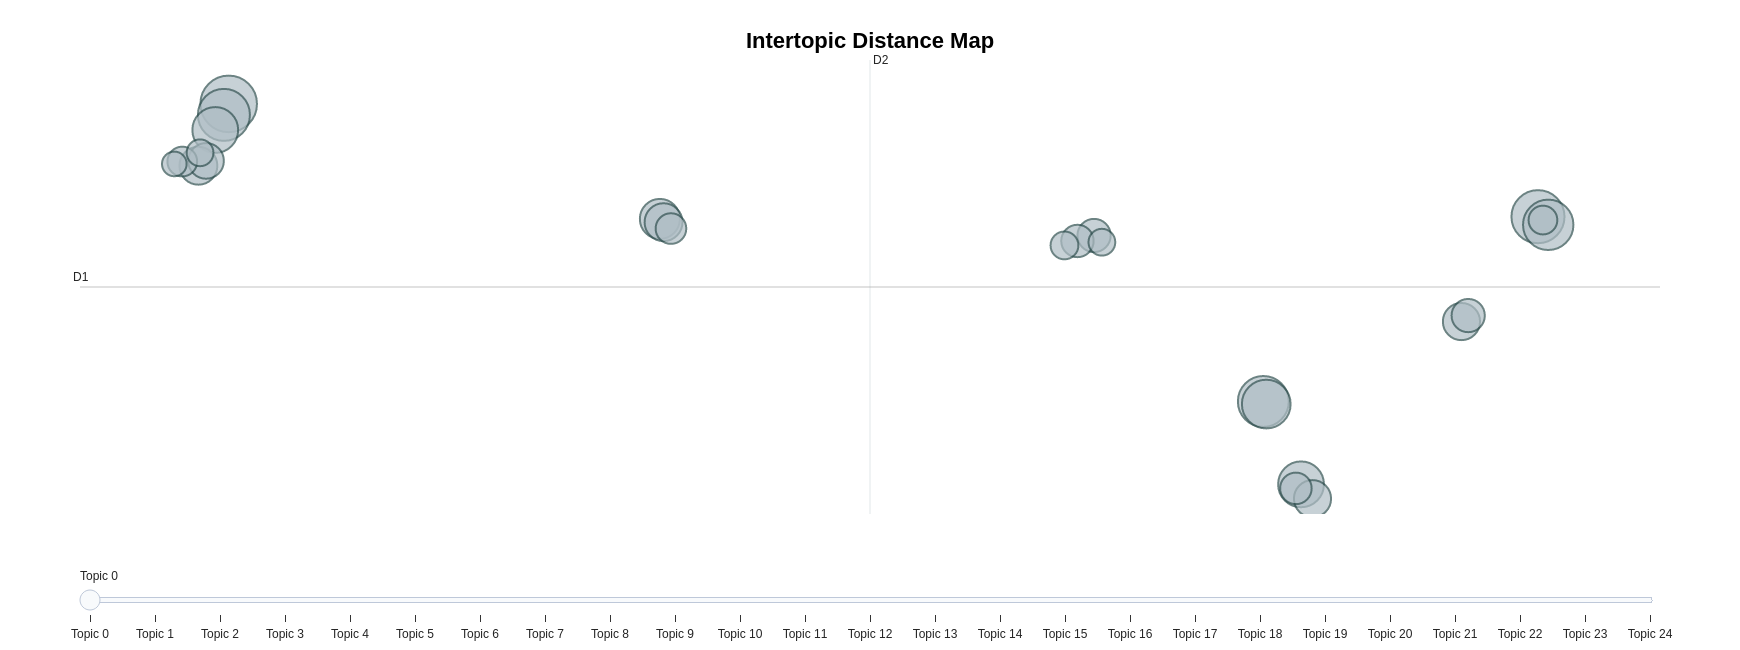

In [48]:
topic_model.visualize_topics()

## Conclusions 

**Use Cases**
- Finding topics in big corpuses 
- Finding keywords for better topic configuration 

**Main Problems**
- Requires hard hyper-parameter tunning  
- Old prototypes work much worse comparing to new ones (Neural Nets + Clustering + TfIdf)
- May require decompostition on steps and each step twicking 

<a id='Homework'></a>
# Homework

Theory:
- Follow all links
- Read about algorithmes and their hyperparameters

Practice:
- Try to build some statistics with `Date` and `Time` features. Number of posts in different months, day of weeks, time of day and etc.
- Try to apply clustering; dimensionality reduction + clustering; topic modelling for finding interesting topics 
- Try to check popularity (number of posts) for the most popular topics from previous step depending on `Date`

Advanced Practice:
- Try to implement some `Class`, which can 
    - Automatically find topics
    - Create descriptions for them: Keywords or/and Keyword N-Grams or/and other rules
    - Detect them and track them by Time